In [2]:
# Interactive 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data 
import pandas as pd
import numpy as np
from numpy.random import seed

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import xgboost as xgb

## Global Settings

In [2]:
seed = 1227
rs = np.random.RandomState(seed) 

## Data

In [3]:
df = pd.read_csv("../data/raw/bank-additional-full.csv", sep=";")

In [4]:
# Memory usage in mb
df.memory_usage(deep=True).sum() / 1024**2

30.26093578338623

In [5]:
# Shape
df.shape

(41188, 21)

### Handle column names

In [6]:
# Convert columns names to snake case
df.columns = [col.lower().replace(".", "_") for col in df.columns]

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

### Check first few rows

In [8]:
df.iloc[:5, :10]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon
1,57,services,married,high.school,unknown,no,no,telephone,may,mon
2,37,services,married,high.school,no,yes,no,telephone,may,mon
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon
4,56,services,married,high.school,no,no,yes,telephone,may,mon


In [9]:
df.iloc[:5, 10:]

,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## EDA

### Data Types

In [10]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                  object
dtype: object

In [11]:
# String columns
str_col = {col: dtype for col, dtype in zip(df.columns, df.dtypes) if str(dtype).startswith('object')}
len(str_col)
str_col

11

{'job': dtype('O'),
 'marital': dtype('O'),
 'education': dtype('O'),
 'default': dtype('O'),
 'housing': dtype('O'),
 'loan': dtype('O'),
 'contact': dtype('O'),
 'month': dtype('O'),
 'day_of_week': dtype('O'),
 'poutcome': dtype('O'),
 'y': dtype('O')}

In [12]:
# Numeric columns
num_col = {col: dtype for col, dtype in zip(df.columns, df.dtypes) if str(dtype).startswith('int') or str(dtype).startswith('float')}
len(num_col)
num_col

10

{'age': dtype('int64'),
 'duration': dtype('int64'),
 'campaign': dtype('int64'),
 'pdays': dtype('int64'),
 'previous': dtype('int64'),
 'emp_var_rate': dtype('float64'),
 'cons_price_idx': dtype('float64'),
 'cons_conf_idx': dtype('float64'),
 'euribor3m': dtype('float64'),
 'nr_employed': dtype('float64')}

### Downcast Continuous Variables

Some of the numeric variables can be downcasted to save memory:

In [13]:
for data_type in [np.int8, np.int16, np.int32]:
    {'max': np.iinfo(data_type).max, 'min': np.iinfo(data_type).min}

{'max': 127, 'min': -128}

{'max': 32767, 'min': -32768}

{'max': 2147483647, 'min': -2147483648}

In [14]:
for data_type in [np.float32, np.float64, np.float128]:
    {'max': np.finfo(data_type).max, 'min': np.finfo(data_type).min}

{'max': 3.4028235e+38, 'min': -3.4028235e+38}

{'max': 1.7976931348623157e+308, 'min': -1.7976931348623157e+308}

{'max': 1.189731495357231765e+4932, 'min': -1.189731495357231765e+4932}

In [15]:
# Max and min values for each numeric column
df[num_col.keys()].apply(lambda col: (col.max(), col.min()))

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,98,4918,56,999,7,1.4,94.767,-26.9,5.045,5228.1
1,17,0,1,0,0,-3.4,92.201,-50.8,0.634,4963.6


In [16]:
# Downcast integer columns
df[df.select_dtypes(include=['int64']).columns] = df.select_dtypes(include=['int64']).astype(np.int16)
# Campain can be cased as int8
df['campaign'] = df['campaign'].astype(np.int8)

In [17]:
# Downcast float columns
df[df.select_dtypes(include=['float']).columns] = df.select_dtypes(include=['float']).astype(np.float32)

In [18]:
# Sanity check
df[num_col.keys()].apply(lambda col: (col.max(), col.min()))

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,98,4918,56,999,7,1.4,94.766998,-26.900000,5.045,5228.100098
1,17,0,1,0,0,-3.4,92.200996,-50.799999,0.634,4963.600098


In [19]:
# New numeric columns dictionary
num_col = dict(df[num_col.keys()].dtypes)
num_col

{'age': dtype('int16'),
 'duration': dtype('int16'),
 'campaign': dtype('int8'),
 'pdays': dtype('int16'),
 'previous': dtype('int16'),
 'emp_var_rate': dtype('float32'),
 'cons_price_idx': dtype('float32'),
 'cons_conf_idx': dtype('float32'),
 'euribor3m': dtype('float32'),
 'nr_employed': dtype('float32')}

In [20]:
# Check memory usage
df.memory_usage(deep=True).sum() / 1024**2

28.25765895843506

The data types look correct for what they represent; we can now plot the continuous variables to get a better sense of their distribution. We may need to adjust the data types or conduct feature engineering for the economic indicator variables. 

### Univariate Plot

In [21]:
# Add a numeric label column for plotting, which will be processed later
df['label'] = df['y'].map({'yes': 1, 'no': 0}).astype(np.int8)

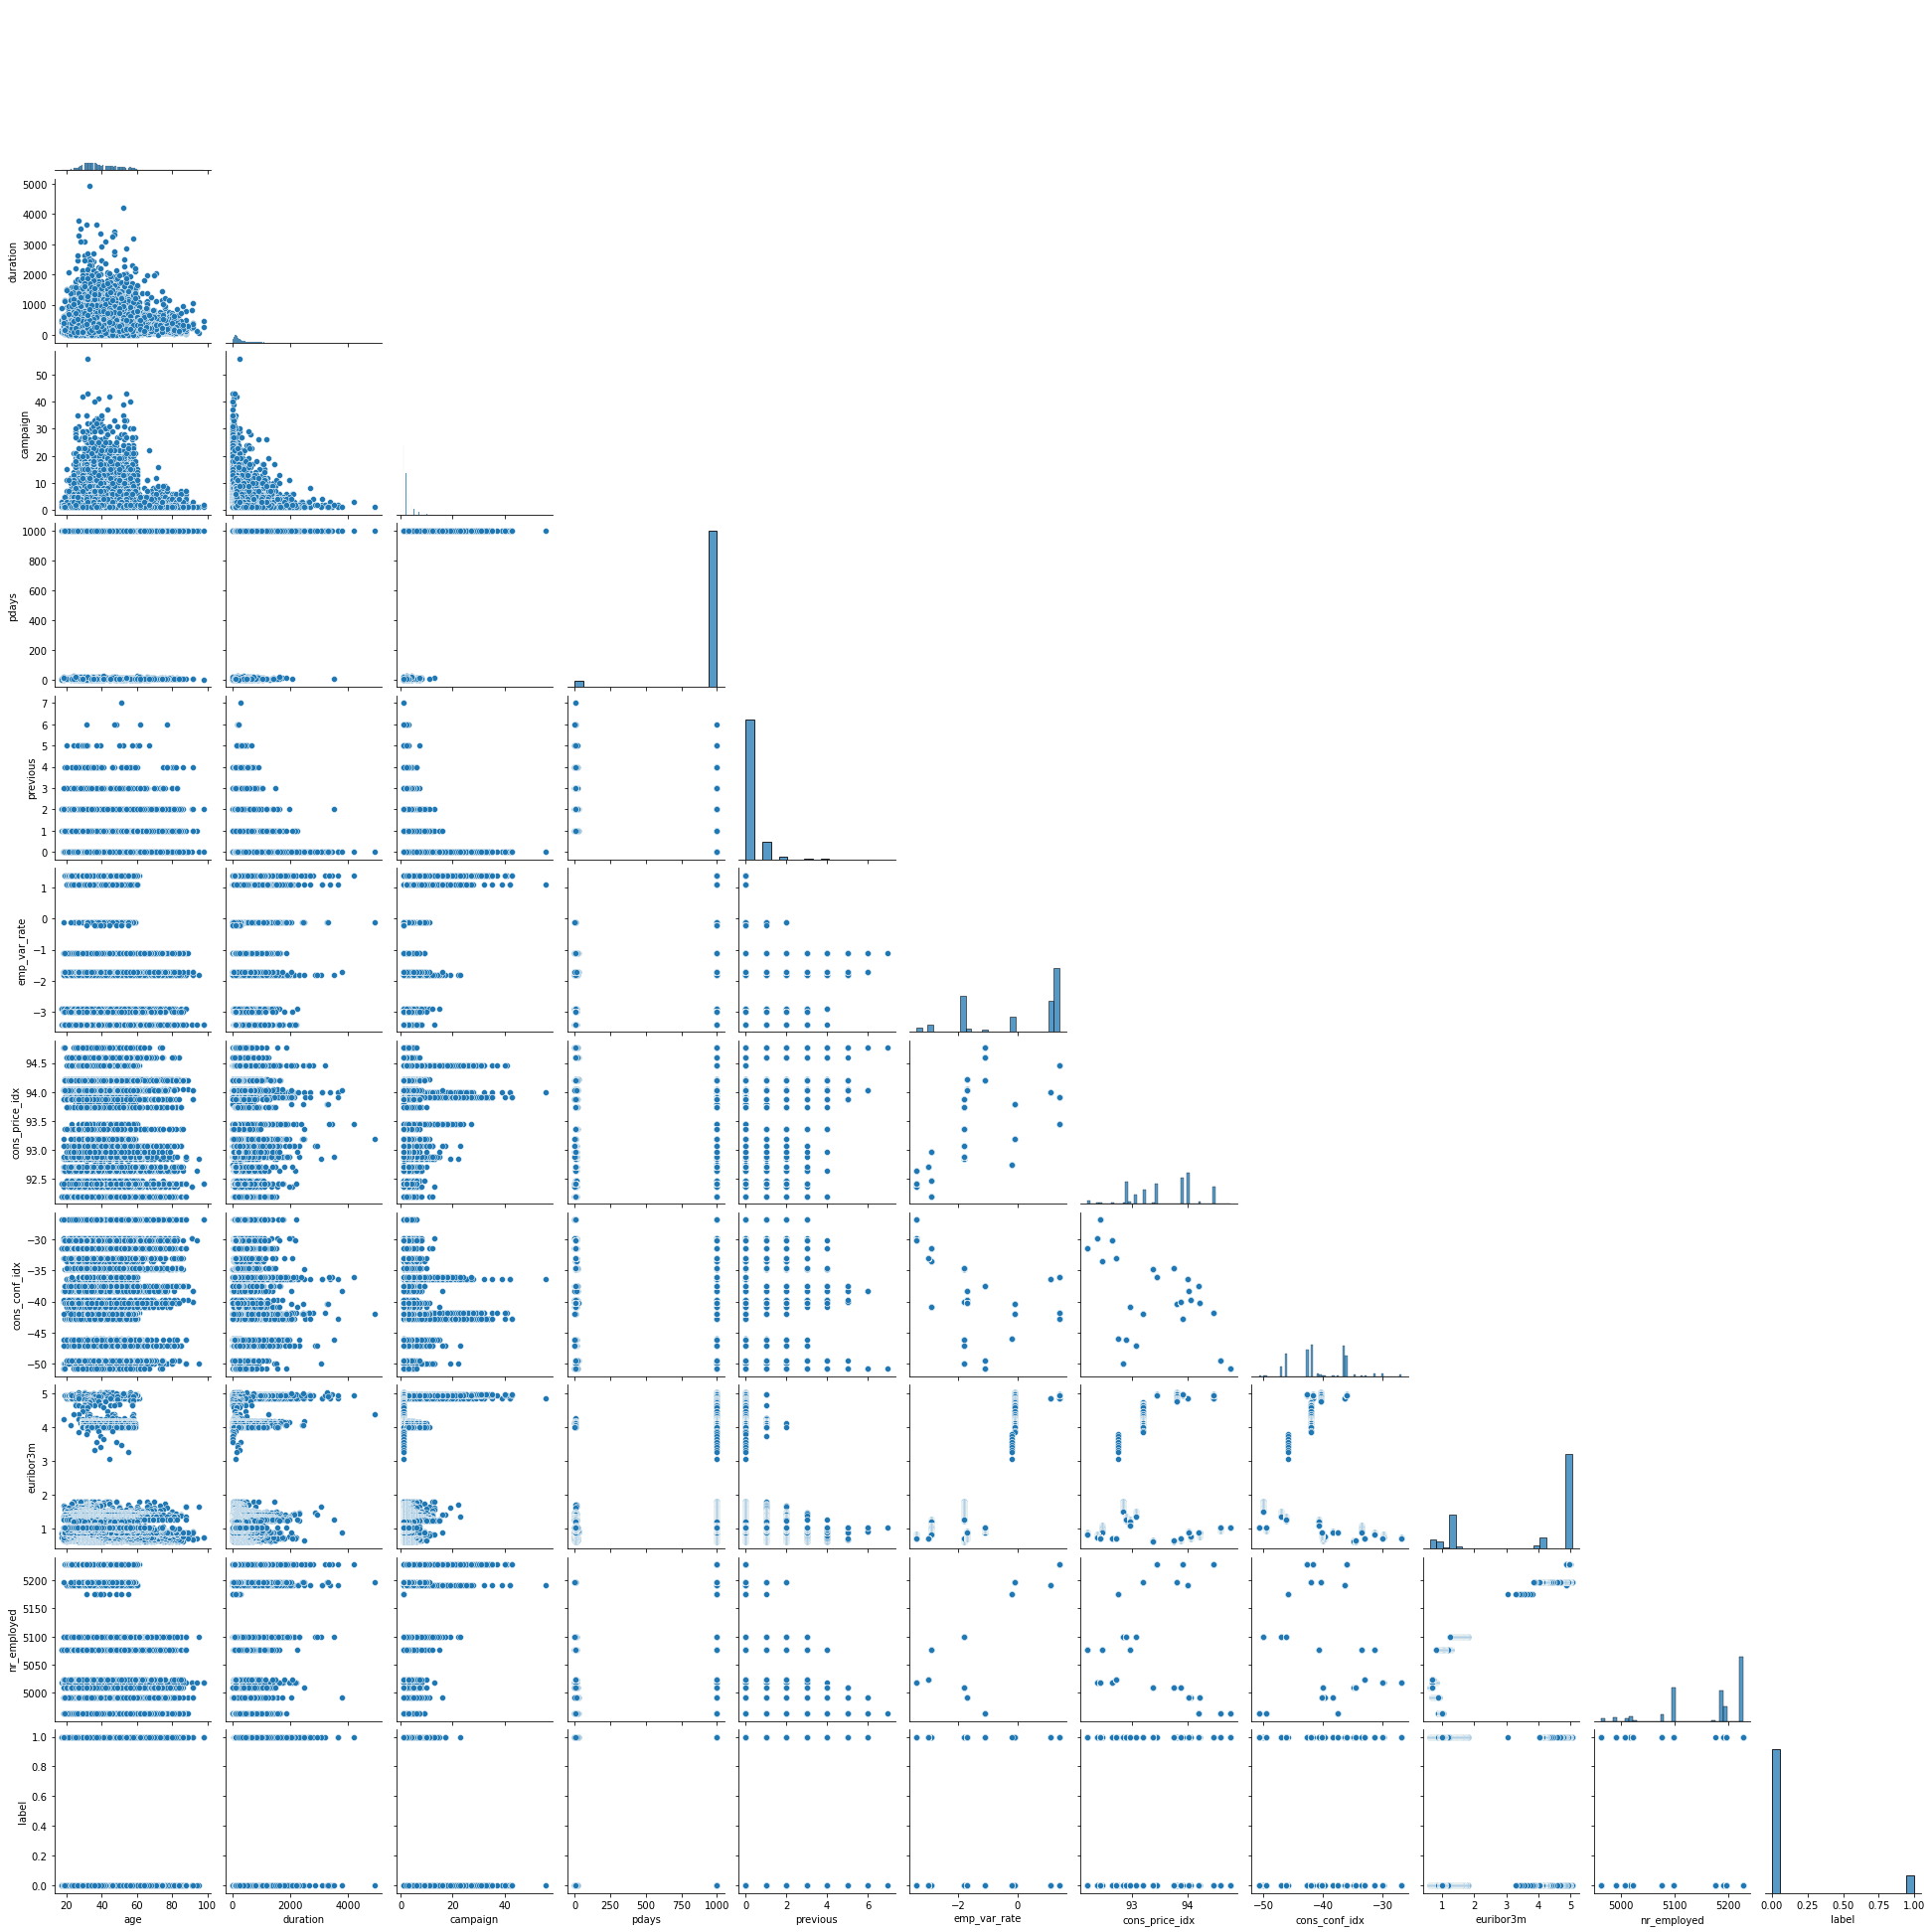

In [22]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.pairplot(df[list(num_col.keys()) + ['label']], corner=True)

### Univariate Correlation

In [23]:
df[list(num_col.keys()) + ['label']].corr().style.background_gradient(cmap='plasma')

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,label
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775335,0.196041,0.972245,0.906970,-0.298334
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775335,1.000000,0.058988,0.688231,0.522034,-0.136211
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058988,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688231,0.277686,1.000000,0.945154,-0.307771
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


* Interestingly, the higher the number of contacts performed during the campaign, the less likely that the client subscribes.

* Consumer price index is highly and positively correlated with employment variation rate, as expected.

* Last contact duration is also highly correlated with the label in the positive direction. However, the duration of the contact is not known before a call is performed. **Thus, this input should be discarded if the intention is to have a realistic predictive model.**

* The label is also correlated with economic indicator variables.

In [24]:
df.drop('label', axis=1, inplace=True)

### Examine Categories in String Columns

In [25]:
for col in str_col.keys():
    print(df[col].value_counts(dropna=False), '\n')

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64 

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64 

no         32588
unknown     8597
yes            3
Name: default, dtype: int64 

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64 

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64 

cellular     26144
telephone    15044
Name: contact, dtype: int64 

may    13769
jul     717

As can be seen, missing values in the categorical variables are all coded with the "unknown" label, which can be treated as a class on its own.

In [26]:
# No explicit missing values
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

## Train Test Split

Based on the EDA, we see that the dataset is highly imbalanced, and so we should preserve the imbalanced nature of the data by using stratified shuffle split, which preserves the distribution of the two classes--- 'yes' and 'no'.

In [27]:
df.y.value_counts(dropna=False)

no     36548
yes     4640
Name: y, dtype: int64

Compute the imbalanced degree:

In [28]:
print(
    'minority class proportions', ((df.y.value_counts(dropna=False)[1] / df.shape[0]) * 100).round(2), '\n'
    'majority class proportions', ((df.y.value_counts(dropna=False)[0] / df.shape[0]) * 100).round(2)
)

minority class proportions 11.27 
majority class proportions 88.73


The data is moderately imbalanced based on [Google's ML developer course](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data).

In [29]:
# Stratified shuffle split based on label
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=rs)
type(sss)

sklearn.model_selection._split.StratifiedShuffleSplit

In [30]:
for train_index, test_index in sss.split(X=df, y=df['y']):
    train = df.loc[train_index]
    test = df.loc[test_index]

Sanity check for class proportions:

In [31]:
print(
    'train minority class proportions', ((train.y.value_counts(dropna=False)[1] / train.shape[0]) * 100).round(2), '\n'
    'train majority class proportions', ((train.y.value_counts(dropna=False)[0] / train.shape[0]) * 100).round(2)
)

train minority class proportions 11.27 
train majority class proportions 88.73


In [32]:
print(
    'test minority class proportions', ((test.y.value_counts(dropna=False)[1] / test.shape[0]) * 100).round(2), '\n'
    'test majority class proportions', ((test.y.value_counts(dropna=False)[0] / test.shape[0]) * 100).round(2)
)

test minority class proportions 11.26 
test majority class proportions 88.74


In [225]:
# Write to disk
train.drop('y', axis=1).to_parquet('../data/train_test/train_X.parquet', index=False)
pd.DataFrame(train['y']).to_parquet('../data/train_test/train_y.parquet', index=False)
test.drop('y', axis=1).to_parquet('../data/train_test/test_X.parquet', index=False)
pd.DataFrame(test['y']).to_parquet('../data/train_test/test_y.parquet', index=False)

## PCA

We will conduct PCA on the continuous columns to explore the training data in more depth: 

In [165]:
# Number of unique values
for col in train.select_dtypes(include=['number']).columns:
    print(col, train[col].unique().size)

age 78
duration 1472
campaign 40
pdays 27
previous 8
emp_var_rate 10
cons_price_idx 26
cons_conf_idx 26
euribor3m 313
nr_employed 11


In [166]:
pca_train = train.select_dtypes(include=['number'])
pca_train

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
29024,44,921,2,999,1,-1.8,93.074997,-47.099998,1.405,5099.100098
21104,35,139,3,999,0,1.4,93.444000,-36.099998,4.963,5228.100098
40121,66,317,1,999,0,-1.7,94.214996,-40.299999,0.835,4991.600098
33953,39,143,1,999,1,-1.8,92.892998,-46.200001,1.281,5099.100098
29684,57,108,1,999,0,-1.8,93.074997,-47.099998,1.405,5099.100098
...,...,...,...,...,...,...,...,...,...,...
31321,36,197,1,999,1,-1.8,92.892998,-46.200001,1.334,5099.100098
555,40,195,1,999,0,1.1,93.994003,-36.400002,4.857,5191.000000
18652,54,20,27,999,0,1.4,93.917999,-42.700001,4.968,5228.100098
26693,33,98,1,999,0,-0.1,93.199997,-42.000000,4.076,5195.799805


In [167]:
# Standardize the data
scaled_pca_train = StandardScaler().fit_transform(pca_train)
scaled_pca_train.shape
scaled_pca_train

(32950, 10)

array([[ 0.3837289 ,  2.5655444 , -0.2049196 , ..., -1.4276062 ,
        -1.2773857 , -0.937277  ],
       [-0.47956282, -0.45744798,  0.15706511, ...,  0.94999534,
         0.7731883 ,  0.8446928 ],
       [ 2.4939976 ,  0.23065005, -0.56690425, ...,  0.04218367,
        -1.6058927 , -2.422252  ],
       ...,
       [ 1.3429419 , -0.9174686 ,  8.844697  , ..., -0.47656608,
         0.77607   ,  0.8446928 ],
       [-0.67140543, -0.6159425 , -0.56690425, ..., -0.325264  ,
         0.26198584,  0.39850563],
       [ 0.47965017,  0.26157582, -0.56690425, ...,  0.94999534,
         0.77434117,  0.8446928 ]], dtype=float32)

In [168]:
# PCA and keep all 10 components
pca = PCA(n_components=10)
pca.fit(scaled_pca_train)

PCA(n_components=10)

### Scree Plot

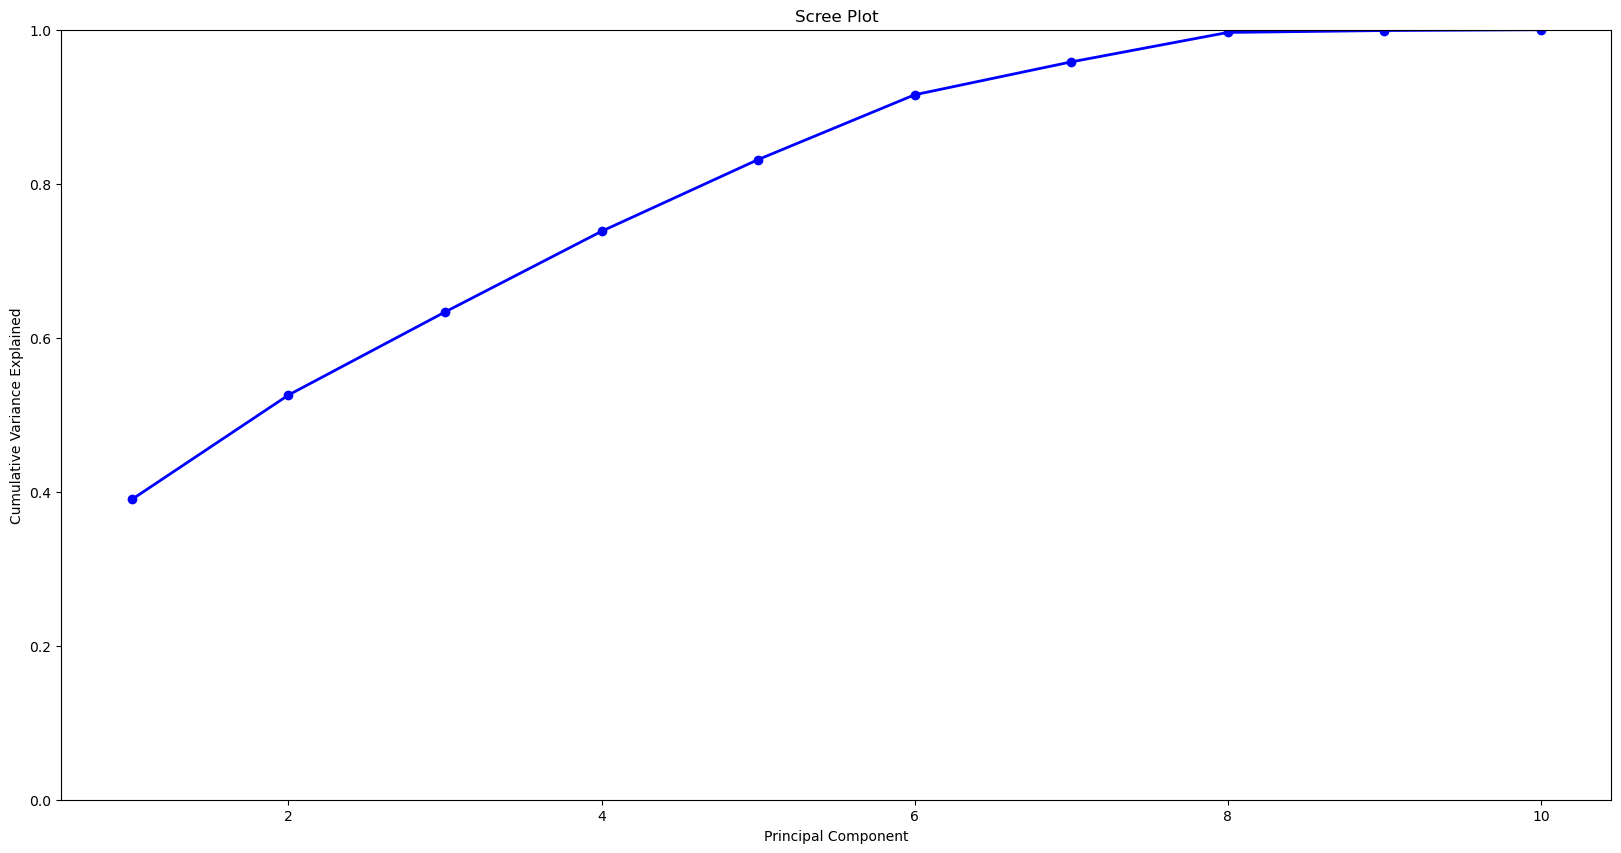

In [169]:
plt.plot(np.arange(pca.n_components_) + 1, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylim(0, 1.0)
plt.ylabel('Cumulative Variance Explained')
plt.show();

In [170]:
perc = pd.DataFrame(
    {
        'pc': ['PC' + str(i) for i in range(1, 11)],
        'Cumulative Variance Explained': np.cumsum(pca.explained_variance_ratio_)
    }
)
perc

,pc,Cumulative Variance Explained
0,PC1,0.389973
1,PC2,0.525545
2,PC3,0.633379
3,PC4,0.738209
4,PC5,0.831370
5,PC6,0.915528
6,PC7,0.958214
7,PC8,0.996452
8,PC9,0.998945
9,PC10,1.000000


* The first two PC's explain ~$52\%$ of variance

* The first five PC's explain ~$83\%$ of variance

* It takes six PC's to explain > $90\%$ of variance

### 3D Plot Using First Three PC's

In [171]:
# Construct the principal components
scaled_pca_train.shape, pca.components_.T.shape
pc = scaled_pca_train @ pca.components_.T

((32950, 10), (10, 10))

In [184]:
pc = pd.DataFrame(pc, columns=['PC ' + str(i) for i in range(1, 11)])
# Add label for plotting
pc['label'] = train['y'].to_numpy()
pc

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,label
0,2.665079,-0.280649,0.116353,1.901938,1.962124,-0.499436,-0.363358,1.122656,0.049416,-0.028979,no
1,-1.378075,0.140612,-0.174746,-0.336872,-0.707530,0.830467,-0.537251,0.101113,-0.193173,-0.082685,no
2,1.978237,0.294768,-1.796768,-0.404335,1.166119,-1.461991,2.570037,-0.451037,-0.108527,0.001645,yes
3,2.750602,-0.642080,0.479435,-0.102534,-0.293463,-0.892966,-0.409100,1.048815,-0.040503,-0.077868,no
4,1.996753,-1.152253,-0.941098,-0.714701,0.508652,-1.728115,0.056641,-0.503119,0.006959,-0.021182,no
...,...,...,...,...,...,...,...,...,...,...,...
32945,2.741360,-0.694668,0.627571,0.147821,-0.301313,-0.695669,-0.414335,1.062384,-0.037972,-0.052601,no
32946,-1.277233,0.486749,-0.509583,0.146006,-0.730536,0.094890,0.430698,0.026776,-0.017145,0.065043,no
32947,-2.409008,0.126879,2.997570,-5.650083,5.638117,2.236919,-0.316076,-0.014353,-0.047131,0.087389,no
32948,-0.102452,-0.811947,0.108866,0.022130,-0.969259,-0.031028,-0.639247,-0.142552,0.080942,0.166760,no


In [185]:
fig = px.scatter_3d(pc, x='PC 1', y='PC 2', z='PC 3', color='label', width=1000, height=500)
fig.update_layout(
    margin=dict(l=15, r=15, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.write_html('../outputs/plots/first_three_pc.html') # Write interactive 3d plot to html file
fig.show();

### Loadings

Examine the loadings for the first 6 principal components:

In [80]:
loadings = pca.components_.T
loadings.shape

(10, 10)

In [81]:
loadings = pd.DataFrame(loadings, columns=['PC ' + str(i) for i in range(1, 11)], index=pca_train.columns)
loadings.iloc[:, :6]

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6
age,-0.000424,0.253527,-0.608769,-0.314052,0.444609,-0.517215
duration,0.026839,0.075707,-0.129628,0.760833,0.584544,0.231485
campaign,-0.099167,-0.006088,0.379275,-0.536425,0.623138,0.412202
pdays,-0.230559,-0.625937,-0.250947,-0.037116,0.054010,0.021796
previous,0.307693,0.472965,0.282402,0.013927,-0.027224,-0.145566
emp_var_rate,-0.487563,0.163655,0.087263,0.055944,-0.029677,-0.075396
cons_price_idx,-0.364749,0.279193,0.271029,0.106497,0.049151,-0.249720
cons_conf_idx,-0.100951,0.432705,-0.494245,-0.127603,-0.245736,0.645518
euribor3m,-0.489962,0.149419,0.000473,0.037960,-0.063213,0.004549
nr_employed,-0.469680,-0.013089,0.025928,0.031410,-0.031516,-0.050690


* Age is pretty important to PC3 trough PC6

* Duration is import to PC4 and PC5 but it should be dropped
  
* The economic indicator variables are important to many PC's

* Employment variation rate, Euribor 3 month rate, number of employees, and consumer confidence index are contributors to the first PC 


### PCA Dimension Guess

In [82]:
guessed_dim = PCA(n_components='mle').fit(scaled_pca_train).n_components_
print('The number of dimension based on Minka\'s MLE is', guessed_dim)

The number of dimension based on Minka's MLE is 9


This is the true dimensionality of the data base on Bayesian model selection.

## Feature Importance For Continuous Variables

In [110]:
# XGBoost parameters
params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'verbosity': 1,
    'subsample': 0.5,
    'random_state': rs,
    'n_jobs': -1
    }  

# XGBoost model
xgb_clf = xgb.XGBClassifier(**params)
xgb_clf

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=1727090694,
              reg_alpha=None, reg_lambda=None, ...)

In [111]:
train_X = train[num_col.keys()]
train_y = train['y'].map({'yes': 1, 'no': 0}).astype(np.int8)
train_X.shape, train_y.shape

((32950, 10), (32950,))

In [112]:
# XGBoost model
xgb_clf.fit(X=train_X, y=train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=1829624311, reg_alpha=0, reg_lambda=1, ...)

In [118]:
# Prediction
pred_y = xgb_clf.predict(test[num_col.keys()])
# Accuracy
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(pred_y, test.y.map({'yes': 1, 'no': 0}).astype(np.int8))))

XGBoost model accuracy score: 0.9158


### Plot

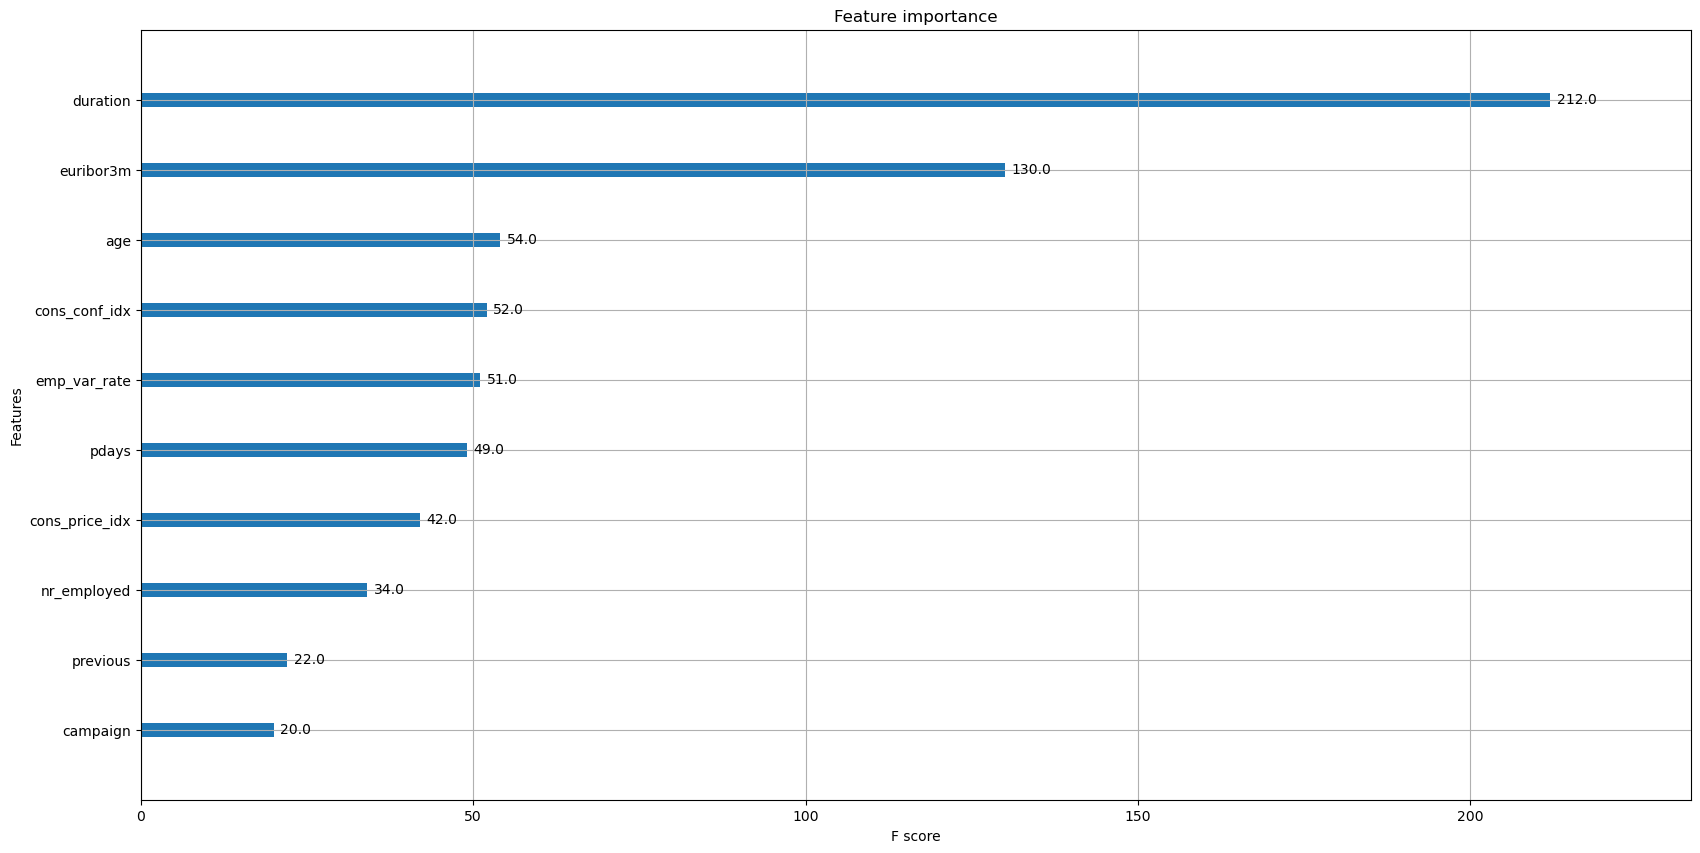

In [131]:
xgb.plot_importance(xgb_clf)
plt.savefig('../outputs/plots/feature_importance_numerical_variable.png', dpi=500, bbox_inches='tight')
plt.show();